# Simulate a Predefined Model

Example created by Wilson Rocha Lacerda Junior

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sysidentpy.polynomial_basis import PolynomialNarmax
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_miso_data, get_siso_data

## Generating 1 input 1 output sample data  
### The data is generated by simulating the following model:

$y_k = 0.2y_{k-1} + 0.1y_{k-1}x_{k-1} + 0.9x_{k-2} + e_{k}$

If *colored_noise* is set to True:

$e_{k} = 0.8\nu_{k-1} + \nu_{k}$

where $x$ is a uniformly distributed random variable and $\nu$ is a gaussian distributed variable with $\mu=0$ and $\sigma=0.1$

In the next example we will generate a data with 1000 samples with white noise and selecting 90% of the data to train the model. 

In [16]:
x_train, x_valid, y_train, y_valid = get_siso_data(n=1000,
                                                   colored_noise=False,
                                                   sigma=0.001,
                                                   train_percentage=90)

One can create a model object and access the build_information_matrix method, the regressor_space method and the Estimator to build a model manually by choosing what regressors you want and estimate the parameters for them. For example:

We already know that the generated data is a result of the model  $𝑦_𝑘=0.2𝑦_{𝑘−1}+0.1𝑦_{𝑘−1}𝑥_{𝑘−1}+0.9𝑥_{𝑘−2}+𝑒_𝑘$ . Thus, we can create a model with those regressors and estimate its parameters as follows:

## Defining the model

In [19]:
# build the object so we can access its functions
model = PolynomialNarmax()

# create any psi matrix that contains the combinations we want
# in this case we want, y(k-1), x(k-2) and y(k-1)x(k-1))
# so the maximum lag of X must be 2 or higher; the maximum lag of y must be 1 or higher and the non_degree must be 2 or higher
# build_information_matrix(X, y, self.xlag, self.ylag, self.non_degree)
psi = model.build_information_matrix(x_train, y_train, 2, 1, 2)

In [20]:
pd.DataFrame(psi)

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.000000,0.108434,-0.610171,0.000000,0.000000,-0.000000,0.011758,-0.066163,0.372308
1,1.0,-0.548087,-0.370476,0.108434,0.300400,0.203053,-0.059431,0.137252,-0.040172,0.011758
2,1.0,0.009140,0.730998,-0.370476,0.000084,0.006681,-0.003386,0.534358,-0.270817,0.137252
3,1.0,-0.332688,0.042290,0.730998,0.110682,-0.014070,-0.243195,0.001788,0.030914,0.534358
4,1.0,0.589887,0.369362,0.042290,0.347967,0.217882,0.024947,0.136428,0.015620,0.001788
...,...,...,...,...,...,...,...,...,...,...
893,1.0,-0.741870,0.489266,-0.685155,0.550371,-0.362971,0.508296,0.239381,-0.335223,0.469437
894,1.0,-0.801757,-0.008684,0.489266,0.642815,0.006963,-0.392272,0.000075,-0.004249,0.239381
895,1.0,0.278465,-0.974898,-0.008684,0.077543,-0.271475,-0.002418,0.950426,0.008466,0.000075
896,1.0,0.019212,-0.014295,-0.974898,0.000369,-0.000275,-0.018729,0.000204,0.013937,0.950426


In [21]:
# we create the code representation to make easier to identifacate the index of the regressors we want.
# regressor_space(non_degree, xlag, ylag, n_inputs)
# 0 is constant, 100n is y(k-n), 200n is x1(k-n), 300n is x2(k-n) and so on
[regressor_code, max_lag] = model.regressor_space(2, 2, 1, 1)
regressor_code

array([[   0,    0],
       [1001,    0],
       [2001,    0],
       [2002,    0],
       [1001, 1001],
       [2001, 1001],
       [2002, 1001],
       [2001, 2001],
       [2002, 2001],
       [2002, 2002]])

Here, $0$ is the constant term, $[1001]=y_{k-1}, \quad [100n]=y_{k-n}, \quad [200n] = x1_{k-n}, \quad [300n]=x2_{k-n}$ and so on

We want the regressors corresponding to the index 1, 3, and 5. So we select the subset of the psi matrix:

In [22]:
model.final_model = regressor_code[[1, 3, 5]] # to use in the predict function

In [23]:
model.final_model

array([[1001,    0],
       [2002,    0],
       [2001, 1001]])

In [24]:
model.psi = psi[:, [1, 3, 5]]

## Defining the parameter estimation method

In [25]:
# by importing the Estimator class you can use any of the parameters estimator methods
from sysidentpy.parameter_estimation import Estimators

In [26]:
# # we use y_train[1:, 0].reshape(-1, 1) because the maximum lag of the selected regressor is 1.
# If maximum lag is 2, we would have used  y_train[2:, 0].reshape(-1, 1) and so on. 

# Note: here we are estimating the parameters of the model, but we can just set the values of theta if we want to simulate 
# pre-defined model. Example: model.theta = np.array([[0.2], [0.9], [0.1]])

model.theta = Estimators().least_squares(model.psi,  y_train[1:, 0].reshape(-1, 1)) 
model.theta

array([[0.20014451],
       [0.89992074],
       [0.09997088]])

## Simulating the model

In [27]:
yhat = model.predict(x_valid, y_valid)

In [28]:
rrse = root_relative_squared_error(y_valid, yhat)
print(rrse)

0.0019184421163563367


In [29]:
model.err = [0, 0, 0] # just to use the `results` method
model.n_terms = 3 # the number of terms we selected (necessary in the 'results' methods)
results = pd.DataFrame(model.results(err_precision=8,
                                     dtype='dec'),
                       columns=['Regressors', 'Parameters', 'ERR'])

print(results)

      Regressors Parameters         ERR
0         y(k-1)     0.2001  0.00000000
1        x1(k-2)     0.8999  0.00000000
2  x1(k-1)y(k-1)     0.1000  0.00000000


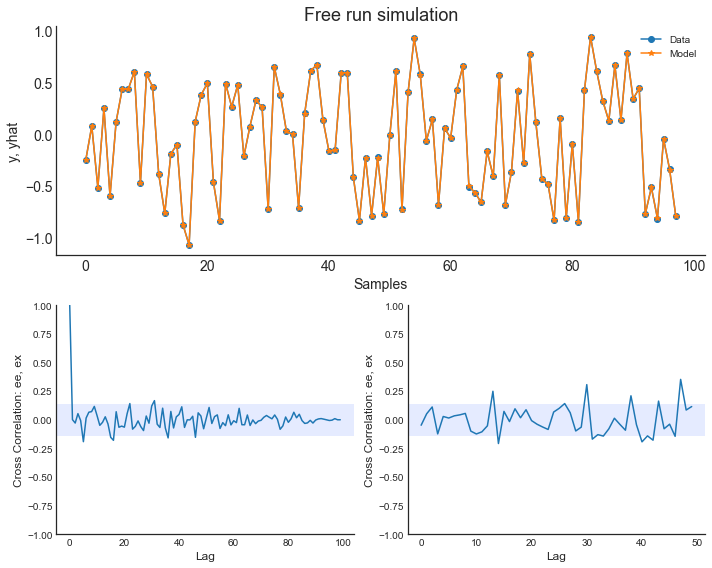

In [30]:
ee, ex, extras, lam = model.residuals(x_valid, y_valid, yhat)
model.plot_result(y_valid, yhat, ee, ex)

## Final code

0.001879953122213705
      Regressors Parameters         ERR
0         y(k-1)     0.2000  0.00000000
1        x1(k-2)     0.8999  0.00000000
2  x1(k-1)y(k-1)     0.1001  0.00000000


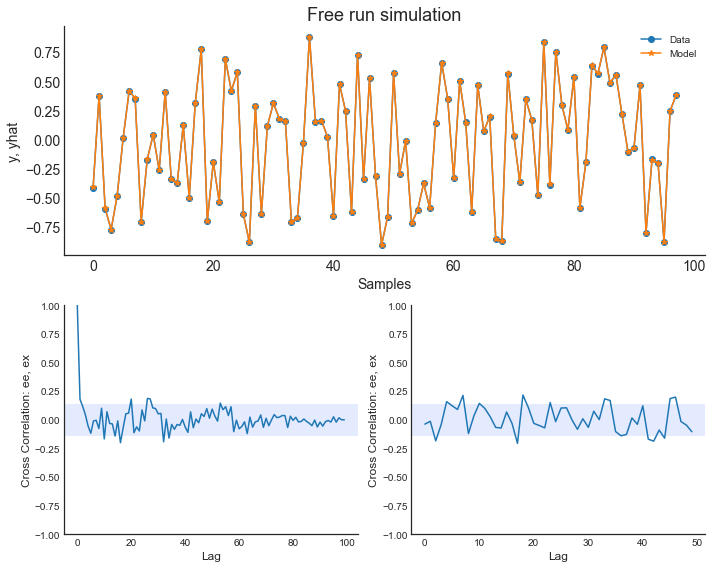

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sysidentpy.polynomial_basis import PolynomialNarmax
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_miso_data, get_siso_data
from sysidentpy.parameter_estimation import Estimators

x_train, x_valid, y_train, y_valid = get_siso_data(n=1000,
                                                   colored_noise=False,
                                                   sigma=0.001,
                                                   train_percentage=90)

model = PolynomialNarmax()
psi = model.build_information_matrix(x_train, y_train, xlag=2, ylag=1, non_degree=2)
[regressor_code, max_lag] = model.regressor_space(2, 2, 1, 1)
model.final_model = regressor_code[[1, 3, 5]] # to use in the predict function
model.psi = psi[:, [1, 3, 5]]
model.theta = Estimators().least_squares(model.psi,  y_train[1:, 0].reshape(-1, 1)) 
yhat = model.predict(x_valid, y_valid)
rrse = root_relative_squared_error(y_valid, yhat)
print(rrse)
model.err = [0, 0, 0] # just to use the `results` method
model.n_terms = 3 # the number of terms we selected (necessary in the 'results' methods)
results = pd.DataFrame(model.results(err_precision=8,
                                     dtype='dec'),
                       columns=['Regressors', 'Parameters', 'ERR'])

print(results)
ee, ex, extras, lam = model.residuals(x_valid, y_valid, yhat)
model.plot_result(y_valid, yhat, ee, ex)